In [3]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import os
from natsort import natsorted

def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(img)
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(img)
    plt.show()

In [61]:
# Path to the folder containing the images
folder_path = "D:/Panorama_normalized"

# Read in the images from the folder and sort them using natsort
files = natsorted(os.listdir(folder_path))
images = [(os.path.join(folder_path, file )) for file in files]


In [10]:
from stitching.image_handler import ImageHandler

img_handler = ImageHandler()
img_handler.set_img_names(images)

medium_imgs = list(img_handler.resize_to_medium_resolution())
low_imgs = list(img_handler.resize_to_low_resolution(medium_imgs))
final_imgs = list(img_handler.resize_to_final_resolution())

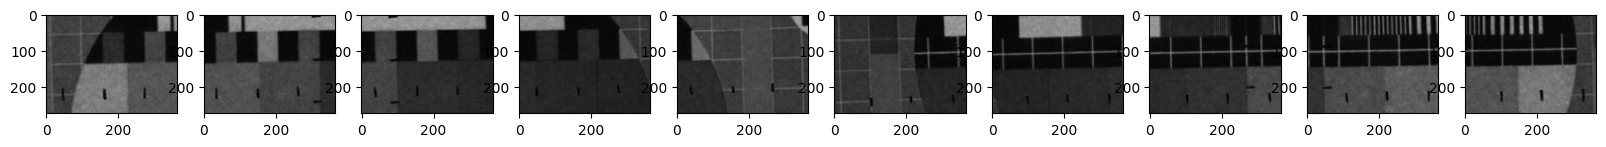

(274, 365, 3)
uint8


In [13]:
plot_images(low_imgs, (20,20))
print(np.shape(low_imgs[1]))
print(low_imgs[1].dtype)

In [14]:
original_size = img_handler.img_sizes[0]
medium_size = img_handler.get_image_size(medium_imgs[0])
low_size = img_handler.get_image_size(low_imgs[0])
final_size = img_handler.get_image_size(final_imgs[0])

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

Original Size: (4056, 3040)  -> 12,330,240 px ~ 1 MP
Medium Size:   (895, 671)  -> 600,545 px ~ 0.6 MP
Low Size:      (365, 274)   -> 100,010 px ~ 0.1 MP
Final Size:    (4056, 3040)  -> 12,330,240 px ~ 1 MP


In [6]:
bit8_images = []

for image in images:
    img8 = (image / 256 ).astype(np.uint8)
    bit8_images.append(img8)
print(bit8_images[0])
print(np.shape(bit8_images[1]))
print(bit8_images[1].dtype)

[[ 39 132  39 ... 207  86 204]
 [126  38 127 ...  88 210  88]
 [ 38 121  38 ... 212  79 211]
 ...
 [103  30  92 ...  57 116  58]
 [ 28 102  29 ... 119  33 119]
 [100  33 100 ...  56 116  57]]
(3040, 4056)
uint8


In [33]:
from stitching.feature_detector import FeatureDetector

finder = FeatureDetector(detector="sift",nfeatures=5000)
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_img = finder.draw_keypoints(medium_imgs[1], features[1],)

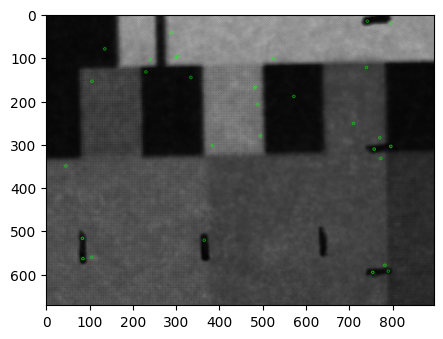

In [34]:
plot_image(keypoints_img, (5,5))

In [35]:
from stitching.feature_matcher import FeatureMatcher

matcher = FeatureMatcher()
matches = matcher.match_features(features)

In [36]:
matcher.get_confidence_matrix(matches)

array([[0.        , 0.63636364, 0.        , 0.        , 0.        ,
        0.3960396 , 0.        , 0.        , 0.40816327, 0.8       ],
       [0.63636364, 0.        , 0.64516129, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.58823529, 0.        ],
       [0.        , 0.64516129, 0.        , 0.        , 0.        ,
        0.        , 0.46728972, 0.74766355, 0.48076923, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.89552239,
        0.        , 0.52631579, 0.53691275, 0.        , 0.4       ],
       [0.        , 0.        , 0.        , 0.89552239, 0.        ,
        1.01796407, 0.38709677, 0.41176471, 0.39106145, 0.37974684],
       [0.3960396 , 0.        , 0.        , 0.        , 1.01796407,
        0.        , 1.01941748, 0.5       , 0.35      , 0.31674208],
       [0.        , 0.        , 0.46728972, 0.52631579, 0.38709677,
        1.01941748, 0.        , 0.72164948, 0.43956044, 0.38277512],
       [0.        , 0.        , 0.7476635

Matches Image 1 to Image 2


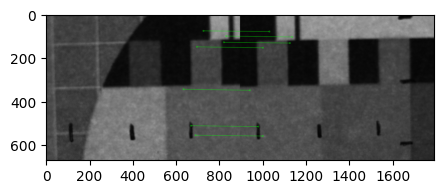

Matches Image 1 to Image 10


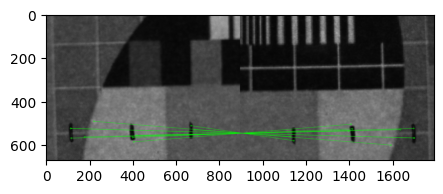

Matches Image 2 to Image 3


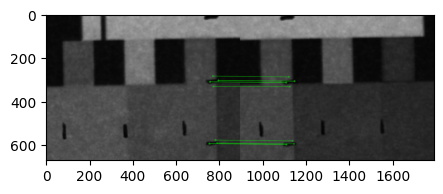

Matches Image 2 to Image 9


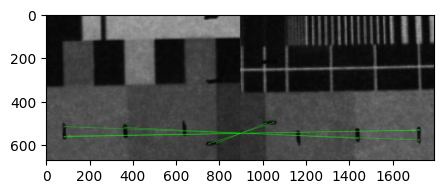

Matches Image 3 to Image 8


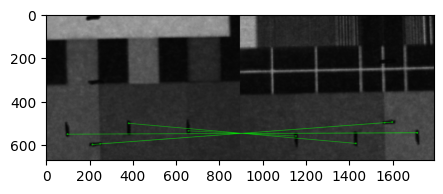

Matches Image 4 to Image 5


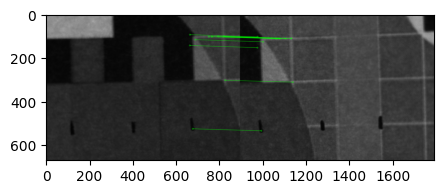

Matches Image 4 to Image 7


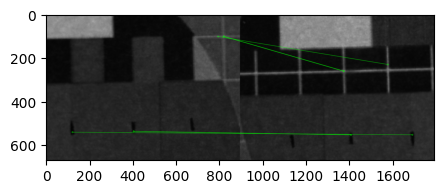

Matches Image 4 to Image 8


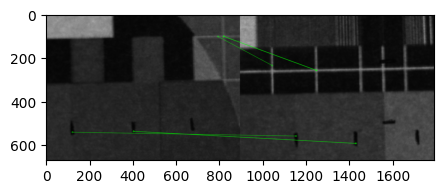

Matches Image 5 to Image 6


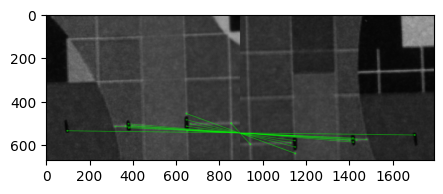

Matches Image 6 to Image 7


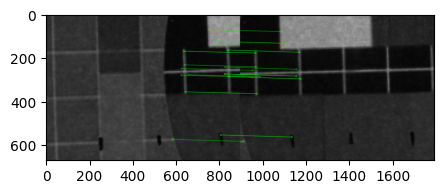

Matches Image 6 to Image 8


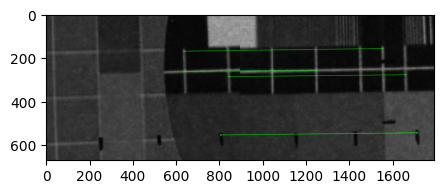

Matches Image 7 to Image 8


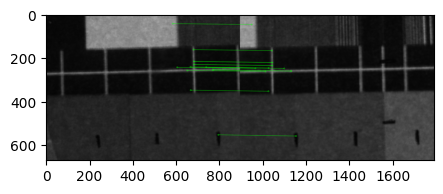

Matches Image 8 to Image 9


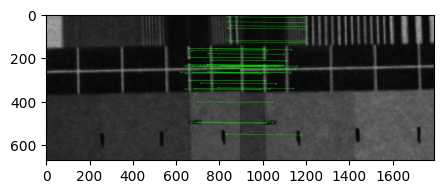

Matches Image 9 to Image 10


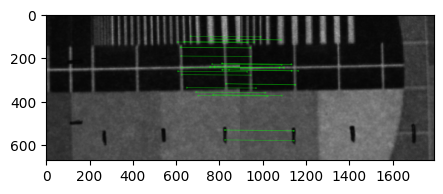

In [37]:
all_relevant_matches = matcher.draw_matches_matrix(medium_imgs, features, matches, conf_thresh=0.5, 
                                                   inliers=True, matchColor=(0, 255, 0))

for idx1, idx2, img in all_relevant_matches:
    print(f"Matches Image {idx1+1} to Image {idx2+1}")
    plot_image(img, (5,5))

In [38]:
from stitching.subsetter import Subsetter

subsetter = Subsetter(confidence_threshold=0.5, matches_graph_dot_file=None)
dot_notation = subsetter.get_matches_graph(img_handler.img_names, matches)
print(dot_notation)

graph matches_graph{
"raw_image_1.tiff" -- "raw_image_2.tiff"[label="Nm=10, Ni=7, C=0.636364"];
"raw_image_1.tiff" -- "raw_image_10.tiff"[label="Nm=15, Ni=10, C=0.8"];
"raw_image_2.tiff" -- "raw_image_3.tiff"[label="Nm=25, Ni=10, C=0.645161"];
"raw_image_2.tiff" -- "raw_image_9.tiff"[label="Nm=13, Ni=7, C=0.588235"];
"raw_image_3.tiff" -- "raw_image_8.tiff"[label="Nm=9, Ni=8, C=0.747664"];
"raw_image_4.tiff" -- "raw_image_5.tiff"[label="Nm=18, Ni=12, C=0.895522"];
"raw_image_4.tiff" -- "raw_image_7.tiff"[label="Nm=24, Ni=8, C=0.526316"];
"raw_image_4.tiff" -- "raw_image_8.tiff"[label="Nm=23, Ni=8, C=0.536913"];
"raw_image_5.tiff" -- "raw_image_6.tiff"[label="Nm=29, Ni=17, C=1.01796"];
}


In [39]:
indices = subsetter.get_indices_to_keep(features, matches)

medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)

img_names = subsetter.subset_list(img_handler.img_names, indices)
img_sizes = subsetter.subset_list(img_handler.img_sizes, indices)

img_handler.img_names, img_handler.img_sizes = img_names, img_sizes

print(img_handler.img_names)
print(matcher.get_confidence_matrix(matches))

['D:/Panorama_normalized\\raw_image_1.tiff', 'D:/Panorama_normalized\\raw_image_2.tiff', 'D:/Panorama_normalized\\raw_image_3.tiff', 'D:/Panorama_normalized\\raw_image_4.tiff', 'D:/Panorama_normalized\\raw_image_5.tiff', 'D:/Panorama_normalized\\raw_image_6.tiff', 'D:/Panorama_normalized\\raw_image_7.tiff', 'D:/Panorama_normalized\\raw_image_8.tiff', 'D:/Panorama_normalized\\raw_image_9.tiff', 'D:/Panorama_normalized\\raw_image_10.tiff']
[[0.         0.63636364 0.         0.         0.         0.3960396
  0.         0.         0.40816327 0.8       ]
 [0.63636364 0.         0.64516129 0.         0.         0.
  0.         0.         0.58823529 0.        ]
 [0.         0.64516129 0.         0.         0.         0.
  0.46728972 0.74766355 0.48076923 0.        ]
 [0.         0.         0.         0.         0.89552239 0.
  0.52631579 0.53691275 0.         0.4       ]
 [0.         0.         0.         0.89552239 0.         1.01796407
  0.38709677 0.41176471 0.39106145 0.37974684]
 [0.3960

In [48]:
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector

camera_estimator = CameraEstimator()
camera_adjuster = CameraAdjuster()
wave_corrector = WaveCorrector()

cameras = camera_estimator.estimate(features, matches)
print(cameras)
cameras = camera_adjuster.adjust(features, matches, cameras)
print(cameras)
cameras = wave_corrector.correct(cameras)
print(cameras)

(< cv2.detail.CameraParams 0000021012199A70>, < cv2.detail.CameraParams 0000021012199F20>, < cv2.detail.CameraParams 0000021012199E30>, < cv2.detail.CameraParams 0000021012199C50>, < cv2.detail.CameraParams 000002101219A010>, < cv2.detail.CameraParams 000002101219A880>, < cv2.detail.CameraParams 000002101219A5B0>, < cv2.detail.CameraParams 000002101219B0F0>, < cv2.detail.CameraParams 000002101219B1E0>, < cv2.detail.CameraParams 000002101219A970>)
(< cv2.detail.CameraParams 0000021012199D40>, < cv2.detail.CameraParams 000002101219AE20>, < cv2.detail.CameraParams 000002101219AF10>, < cv2.detail.CameraParams 000002101219B4B0>, < cv2.detail.CameraParams 000002101219B5A0>, < cv2.detail.CameraParams 000002101219B690>, < cv2.detail.CameraParams 000002101219B960>, < cv2.detail.CameraParams 000002101219BA50>, < cv2.detail.CameraParams 000002101219BD20>, < cv2.detail.CameraParams 000002101219BE10>)
(< cv2.detail.CameraParams 0000021012199D40>, < cv2.detail.CameraParams 000002101219AE20>, < cv2.d

In [49]:
from stitching.warper import Warper

warper = Warper()

In [50]:
warper.set_scale(cameras)

In [51]:
low_sizes = img_handler.get_low_img_sizes()
camera_aspect = img_handler.get_medium_to_low_ratio()      # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

In [52]:
final_sizes = img_handler.get_final_img_sizes()
camera_aspect = img_handler.get_medium_to_final_ratio()    # since cameras were obtained on medium imgs

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

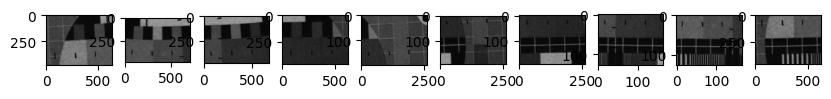

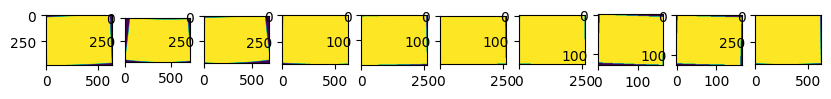

In [53]:
plot_images(warped_low_imgs, (10,10))
plot_images(warped_low_masks, (10,10))

In [ ]:
from stitching.cropper import Cropper

cropper = Cropper()
mask = cropper.estimate_panorama_mask(warped_low_imgs, warped_low_masks, low_corners, low_sizes)
plot_image(mask, (5,5))

In [ ]:
from stitching.seam_finder import SeamFinder

seam_finder = SeamFinder()

seam_masks = seam_finder.find(low_imgs, low_corners, mask)
seam_masks = [seam_finder.resize(seam_mask, mask) for seam_mask, mask in zip(seam_masks, mask)]

seam_masks_plots = [SeamFinder.draw_seam_mask(img, seam_mask) for img, seam_mask in zip(final_imgs, seam_masks)]
plot_images(seam_masks_plots, (15,10))

In [62]:
from stitching import Stitcher
settings = {# The whole plan should be considered
            "crop": False,
            # The matches confidences aren't that good
            "confidence_threshold": 0.5,
            "detector": "sift"} 

stitcher = Stitcher(**settings)
panorama = stitcher.stitch(images)

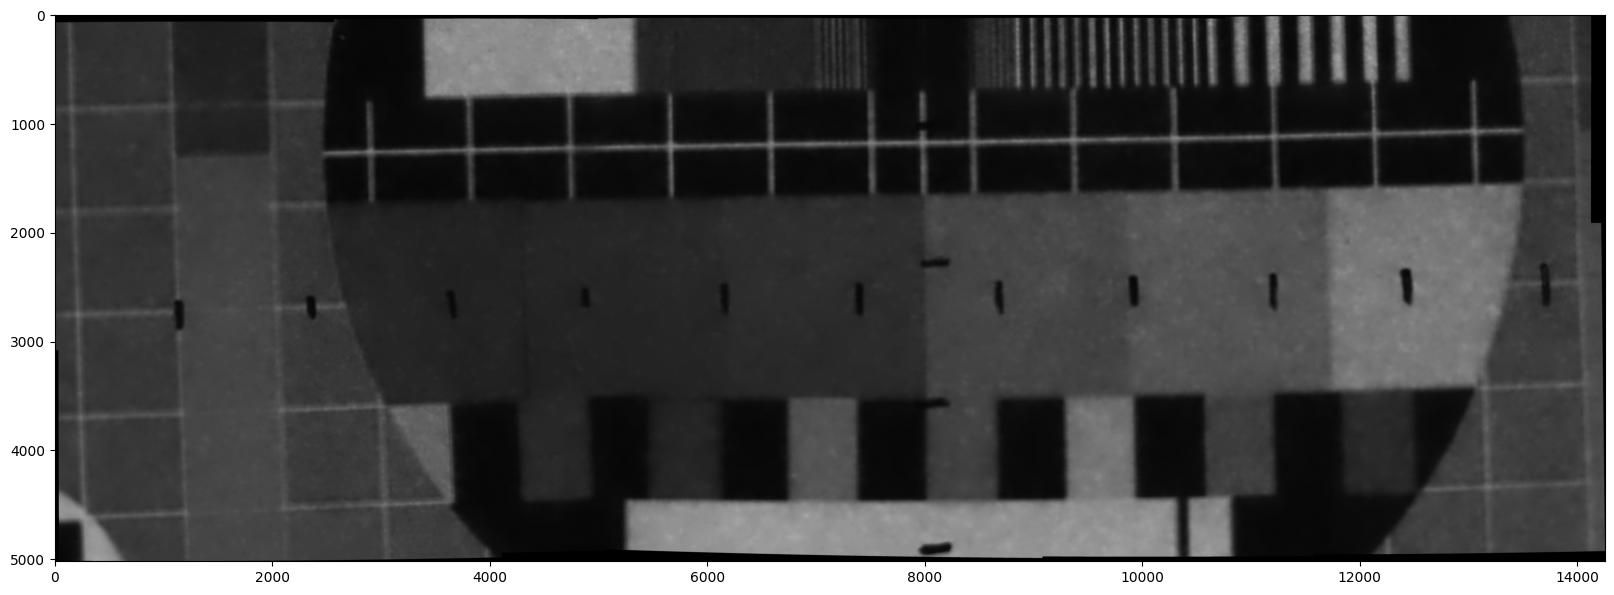

(5021, 14254, 3)
uint8


In [63]:
plot_image(panorama, (20,20))
print(np.shape(panorama))
print(panorama.dtype)

In [20]:
cv.imwrite("D:/panorama.tiff",panorama)

True

In [27]:
pano = cv.imread("D:/panorama.tiff", cv.IMREAD_UNCHANGED)
print(np.shape(pano))
print(pano.dtype)


(5035, 14262, 3)
uint8


In [ ]:
from stitching import AffineStitcher
from stitching import Stitcher

print(AffineStitcher.AFFINE_DEFAULTS)
# Comparison:
print(Stitcher.DEFAULT_SETTINGS)
print(AffineStitcher.DEFAULT_SETTINGS)